# A propaganda *Simulation* - Facts and False Balancing
The following notebook simulates the effects of social networks on opinion propagation.
Based on an interview of Jeff Bezos, the idea underlying the experiments in this notebook are the following: 
Humans are social animals. Social networks propagate opinions about something. Anyway there are opinions that are hard to prove and other opinions -- **facts** -- that are either true (*truth*) or false (*lie*). Even in the second case, **trust** in social networks can cause individuals in the network to believe in the *lie*. Anyway, as said by Jeff Bezos, in a healthy organization (e.g., a company, a state, or a society) usually **truth promoting mechanisms** are in place that give an advantage to the truth over the lie. These mechanism include discussions, scientific method, trustworthy fact-check entities (e.g., research departments), etc.

Still, under some circumstances (e.g., when politicians -- i.e. very central nodes in a network -- spread lies), it might happen that the lie *wins* over the truth. In a very simplified simulation model, we study these effects.

We consider a very **simplified scenario**. In this scenario there is someone who knows the truth and someone else who lies. Individuals in the social network look in their neighborhood (i.e., their first degree relationship). Based on their neighborhood, they change their *believe* about the truth value of the fact. Since there are mechanisms in place that favour the truth over the lie, the true opinion is weighted stronger than the lie. This weight is determined by a free parameter \alpha. E.g., if alpha is 1.5 and 2 neighbors tell the truth while 3 are lieing it would be a tie (and then randomly the opinion will be determined). If alpha is 1.6 in the same scenario, the truth would win, if it's less than 1.5 the lie would win for this node. We then look at the distribution of truth and lie over time.

We look into this distribution based on an initial opionon (or believe) of the social network, especially we try to simulate the impact of **false balancing**.

Note that there are several works on mathematical models and more formal methods to study opinon propagation in social networks. Here, we only study a simplified opinon propagation with simulation, without any rigorous formal proofs.

# Some Interpretations

Some words on trust: Trust might be very dangerous in some cases while it is good in others. We all know people that argue like: ``An expert said this, so you have to believe it.'' This form of trust can be dangerous, because the expert could either lie intentionally, be no expert, or have made some mistakes. Therefore blind trust without any truth favouring mechanisms cause an organization to more likly start believing in a lie, especially when false balancing in favour of the lie is in place.

What we can clearly see from the simulations below is that a false balancing has a huge influence on the opinon propagation (even though in our model the opinon of influencer can be flipped in the same way everyones opinon can be flipped.). 
This even holds true if there are already truth promoting mechanisms in place that favor truth over lies. The false balancing effect (only in the initial opinon setup) kicks in really really hard. 
Roughly speaking, that means, if influencers are balanced, quickly the entire network will be balanced, even if influencers can be influenced like everyone else. 

Relating the results in our experiments to Noam Chomsky's propaganda model quickly shows, that also stable democracies are not necessarily fact seeking organizations. 
Having social network mechanisms for opinion propagation (and humans are social beings) one needs strong truth promoting mechanisms, to counter negative effects or false balancing effects.

Also note that we do not want to state that every question can be answered by facts. Some questions use too vague language, or are too expensive to answer and a healthy gut feeling, experience, or historically similar questions/situations, have to be taken into account to built up an opinion about the topic. Unfortunatley also for facts, we can see that the opinion about these facts can be wrong or highly inbalanced. When talking about *lie*, we do not necessarily mean an intentional lie. It could also be a mistake (e.g., wrong results/measurements in experiments), random behaviour (e.g., an intelligence service that broadcasts false information for distraction).

# Experiments

## Parameter setup

In [9]:
# The experiment parameters
GRAPH_SIZE = 5000

# Initial truth-ratio
TRUTH_RATIO = 0.5

# Initial opinon propagation (i.e., what pecentage of the network has an opinon, i.e., is not neutral)
OPINION_RATIO = 0.4

# Parameters for the skewed (balanced) drawing from the individuals.
# Currently we use beta-distribution to draw from the nodes according to their eigenvector centrality (left = large centrality, right=low centrality)
# Beta-distribution contains uniform distributions (alpha=1, beta=1), but also right-heavy(alpha > beta),or left-heavy(beta > alpha) ones.
TRUTH_ALPHA = 1
TRUTH_BETA = 1
LIE_ALPHA = 1
LIE_BETA = 1.5

# Seed for the random number generator (for reproducability)
RANDOM_SEED=42


# Just of technical nature... you can ignore them
LABEL_NAME = 'label'
TRUTH_LABEL = 0
LIE_LABEL = 1
NEUTRAL_LABEL = 2
SNAPSHOT_EVERY = 1

## Utils (execute but ignore)

In [10]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random

In [11]:
random.seed(RANDOM_SEED)

In [12]:
def draw_graph(G: nx.Graph):
    # draw the digraph
    from networkx.drawing.nx_agraph import graphviz_layout
    labels = nx.get_node_attributes(G, LABEL_NAME)
    pos = graphviz_layout(G, prog="neato")
    plt.figure(1)
    nx.draw(G, pos, arrows=True, node_color="grey", with_labels=True, labels=labels)

    # show the plot
    plt.show()

We define the function that reads out the public opinon from the graph, that is, how many individuals believe in the truth and how many in the lie.

In [13]:
def evaluate(G: nx.Graph):
    all_labels = nx.get_node_attributes(G, LABEL_NAME)
    sum_truth = sum([1 for label in all_labels.values() if label == TRUTH_LABEL])
    sum_lie = sum([1 for label in all_labels.values() if label == LIE_LABEL])
    sum_neutral = sum([1 for label in all_labels.values() if label == NEUTRAL_LABEL])

    return sum_truth / G.number_of_nodes(), sum_lie / G.number_of_nodes(), sum_neutral / G.number_of_nodes()

A method for balanced drawing from a list. Can be adapted to other distributions as well.
Beta-distribution contains uniform distributions (alpha=1, beta=1), but also right-skewed(alpha > beta),
or left-skewed(beta > alpha) ones.

In [14]:
WARNING_THRESHOLD = 0.05
def draw_skewed(list_to_draw: list, sample_size: int, alpha: float, beta:float):
    
    # Other distributions (even real-world ones are conceivable here)
    samples_unit_interval = np.random.beta(alpha,beta, size=sample_size)
   
    # multiply with len of list to get indices over the entire list range
    samples = samples_unit_interval * (len(list_to_draw)-1)

    # round the indices to the nearest integer
    indices = list(set([int(round(sample)) for sample in samples]))
    
    # Note that we could be left with less then sample size samples, we just make sure that we do not loose too many
    if (sample_size - len(indices))/sample_size > WARNING_THRESHOLD:
        print(f"We lost {sample_size - len(indices)} during sampling... If this happens too often consider some fix to this.")

    # now draw from the original list and return
    chosen_entries = [list_to_draw[i] for i in indices]
    
    return chosen_entries

## The social network graph

We define the social network graph.
We could also import some real-world network here. 
For simplicity we generate some random scale-free graph.

In [15]:
def setup_network(network_size:int = GRAPH_SIZE):
    # TODO we can also study the influence of the scale-free-graph parameters
    intermediate = nx.scale_free_graph(network_size)
    # this function returned a graph with a large in degree of central nodes... we basically want the reverse  of this,
    # i.e., central nodes (politicians, media, etc. are huge senders of information and not receivers)
    social_network = intermediate.reverse()
    return social_network

In [16]:
#network = setup_network(50)
#draw_graph(network)

## The initial opinion

Since we want to study false balancing, we sort the individuals in the social network according to their centrality (decending order). Nodes with a larger centrality typically have a larger impact on other nodes (e.g., politicians, media, influencers, stars, etc.). We then define the initial opinion distribution of the *truth* and the *lie* over the individuals.
We draw samples using skewed distributions. Note that these distributions are also some part of our modeling and have to be taken with care since they probably do not conform to real-world distributions of opinions!

In [17]:
def setup_initial_opinon(social_network: nx.Graph, 
                         truth_ratio: float=TRUTH_RATIO, 
                         opinion_ratio:float=OPINION_RATIO,
                         truth_alpha:float=TRUTH_ALPHA,
                         truth_beta:float=TRUTH_BETA,
                         lie_alpha:float=LIE_ALPHA,
                         lie_beta:float=LIE_BETA
                         ):
    # compute the degree centrality for all nodes
    degree_centrality = nx.degree_centrality(social_network)

    # sort the nodes by degree centrality in descending order
    sorted_nodes = sorted(degree_centrality, key=degree_centrality.get, reverse=True)
    
    # number of nodes not being neural
    opinon_node_count = opinion_ratio * len(sorted_nodes)
    
    # number of truth nodes
    truth_node_count = int(truth_ratio * opinon_node_count)
    
    # number of lie nodes
    lie_node_count = int(opinon_node_count - truth_node_count)
    
    # selection for the truth nodes
    truth_nodes = draw_skewed(sorted_nodes, truth_node_count, truth_alpha, truth_beta)
    
    # selection for the lie nodes
    lie_nodes = draw_skewed(sorted_nodes, lie_node_count, lie_alpha, lie_beta)
    
    truth_nodes_labels = {node: {LABEL_NAME: TRUTH_LABEL} for node in truth_nodes}
    lie_nodes_labels = {node: {LABEL_NAME: LIE_LABEL} for node in lie_nodes}
    
    # nodes that are truth and lie stay neutral. We therefore remove them
    keys_in_both = set(truth_nodes_labels.keys()) & set(lie_nodes_labels.keys())
    truth_nodes_labels = {k: truth_nodes_labels[k] for k, _ in truth_nodes_labels.items() if k not in keys_in_both} 
    lie_nodes_labels = {k: lie_nodes_labels[k] for k, _ in lie_nodes_labels.items() if k not in keys_in_both} 


    # Set node labels
    nx.set_node_attributes(social_network, truth_nodes_labels)
    nx.set_node_attributes(social_network, lie_nodes_labels)
   
    return social_network

## The opinion propagation

Now we define the propagation mechanism. This is the easiest i could imagine. The first extension could be to consider propagation more probabilistic. Instead of large value wins one could consider this in a probabilistic manner, i.e., the truth value of the neighborhood define the probablity of assuming the opinon. Furthermore, one could define different characters of nodes. Some that rather check the opinon and have a higher probability to believe the truth and some that rather spread lies, etc. I.e., we can study a lot here but we wanted to keep things simple.

In [18]:
def propagate_step(G: nx.Graph, alpha=1.5) -> nx.Graph:
    # For every node, we retrieve it's in-neighborhood.
    nodes = G.nodes()
    # graph node labels (truth values)
    all_labels = nx.get_node_attributes(G, LABEL_NAME)
    
    node_labels = dict()
    for node in nodes:
        
        if node in all_labels.keys():
            node_label = all_labels[node]
        else:
            node_label = NEUTRAL_LABEL            
        
        # get the in neighbors of node n
        in_neighbors = list(G.predecessors(node))
        
        # We select and count all turth neighbors... can be done more efficiently... in case this becomes a bottleneck
        true_neighbors = [neighbor for neighbor in in_neighbors if neighbor in all_labels.keys() and all_labels[neighbor] == TRUTH_LABEL]
        lie_neighbors = [neighbor for neighbor in in_neighbors if neighbor in all_labels.keys() and all_labels[neighbor] == LIE_LABEL]
        
        sum_truth = len(true_neighbors)
        sum_lie = len(lie_neighbors)
        
        value_truth = sum_truth*alpha
        value_lie = sum_lie
        
        # add the original believe
        if node_label == TRUTH_LABEL:
            value_truth += 1*alpha
        elif node_label == LIE_LABEL:
            value_lie += 1
        
        # special case - not a known topic yet
        if value_truth == 0 and value_lie == 0:
            new_label = NEUTRAL_LABEL
        elif value_truth > value_lie:
            new_label = TRUTH_LABEL
        elif value_truth < value_lie:
            new_label = LIE_LABEL
        # a tie
        else:
            new_label = NEUTRAL_LABEL
            
        node_labels[node] = {LABEL_NAME: new_label}
    
    nx.set_node_attributes(G, node_labels)
    return G
        

Here come the propagation. We iterate the propagation several times (using a time parameter) and extract the ratio of truth, lie, and neutral opions from the network.

In [19]:
def propagate_loop(social_network: nx.Graph, timesteps:int, propagate_alpha:float=1.5):
    idx = [-1]
    truth_list = []
    lie_list = []
    neutral_list = []
    p_truth, p_lie, p_neutral = evaluate(social_network)
    truth_list.append(p_truth)
    lie_list.append(p_lie)
    neutral_list.append(p_neutral)

    for time_step in range(timesteps):
        social_network = propagate_step(social_network, alpha=propagate_alpha)
        if time_step % SNAPSHOT_EVERY == 0:
            idx.append(time_step)
            p_truth, p_lie, p_neutral = evaluate(social_network)
            truth_list.append(p_truth)
            lie_list.append(p_lie)
            neutral_list.append(p_neutral)
    
    return social_network, idx, truth_list, lie_list, neutral_list

## Experiment Execution and Evaluation

Note that the propagation is kind of static.
The trajectory is determined solely by the parameter alpha corresponding to the increased likelyhood of believing the truth,
and the initial distribution of the opinon and the skewedness of truth/lie towards central nodes (politicians, media etc.)

In [20]:
social_network = setup_network()
setup_initial_opinon(social_network=social_network)
print(evaluate(social_network))


social_network, idx, truth_list, lie_list, neutral_list = propagate_loop(social_network=social_network, timesteps=10, propagate_alpha=1.5)

We lost 83 during sampling... If this happens too often consider some fix to this.
We lost 101 during sampling... If this happens too often consider some fix to this.
(0.1544, 0.1508, 0.0)


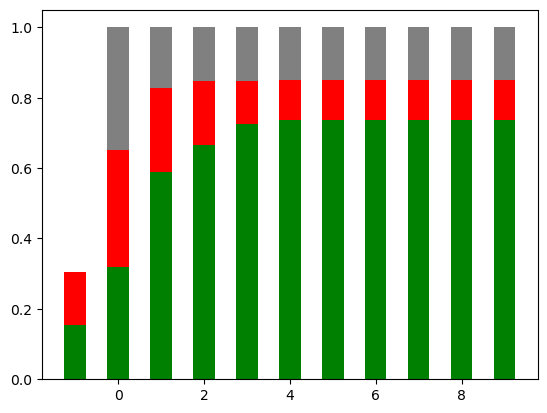

In [21]:
# Stacked bar chart
plt.bar(idx, truth_list, width = 0.5, color='green')
plt.bar(idx, lie_list, bottom = truth_list, width=0.5, color='red')
plt.bar(idx, neutral_list, bottom = np.add(truth_list, lie_list), width=0.5, color='grey')
plt.show()

## A phase plot for the False Balancing

Now, we vary the alpha terms (for the balancing in the most influencing individuals) for truth and lie in the initial setup and plot the majority in a two dimensional space.

In [26]:
# Truth promotion alpha
TRUTH_PROMOTION_ALPHA = 2 # Large truth enforcements. it needs more than 3 liers to win over 2 people telling the truth....
TIMESTAMPS_PER_PROPAGATION = 10
step_size=0.05

number_of_steps = int((2 - 1)/step_size)

# we iterate over the alpha space from 1 to 2 in a grid loop 
outcomes = []
for truth_alpha in np.arange(1, 2, step_size): 
    for lie_alpha in np.arange(1, 2, step_size): 
        social_network = setup_network()
        setup_initial_opinon(social_network=social_network, 
                         truth_ratio=TRUTH_RATIO, 
                         opinion_ratio=OPINION_RATIO,
                         truth_alpha=truth_alpha,
                         truth_beta=TRUTH_BETA,
                         lie_alpha=lie_alpha,
                         lie_beta=LIE_BETA
                         )
        social_network, idx, truth_list, lie_list, neutral_list = propagate_loop(social_network=social_network, timesteps=TIMESTAMPS_PER_PROPAGATION, propagate_alpha=TRUTH_PROMOTION_ALPHA)
        value_final = (truth_list[-1]/(truth_list[-1] + lie_list[-1]))
        outcomes.append([truth_alpha, lie_alpha, value_final])

We lost 106 during sampling... If this happens too often consider some fix to this.
We lost 106 during sampling... If this happens too often consider some fix to this.
We lost 86 during sampling... If this happens too often consider some fix to this.
We lost 110 during sampling... If this happens too often consider some fix to this.
We lost 101 during sampling... If this happens too often consider some fix to this.
We lost 105 during sampling... If this happens too often consider some fix to this.
We lost 87 during sampling... If this happens too often consider some fix to this.
We lost 81 during sampling... If this happens too often consider some fix to this.
We lost 103 during sampling... If this happens too often consider some fix to this.
We lost 93 during sampling... If this happens too often consider some fix to this.
We lost 93 during sampling... If this happens too often consider some fix to this.
We lost 104 during sampling... If this happens too often consider some fix to thi

In [28]:
plot_values = np.array(outcomes)
import matplotlib.colors as mcolors
cmap = mcolors.LinearSegmentedColormap.from_list('ggr', [(0, 'red'), (0.5, 'grey'), (1, 'green')])

X, Y = np.meshgrid(plot_values[:, 0], plot_values[:, 1])

In [29]:
number_of_steps = int((2 - 1)/step_size)
number_of_values = number_of_steps**2
z = np.zeros((number_of_values,number_of_values))
for i in range(number_of_values):
    for j in range(number_of_values):
        it_truth = (X[i,j] - 1)/ step_size
        it_lie = (Y[i,j] - 1)/ step_size
        color_index = int(round(it_truth*number_of_steps + it_lie))
        z[i,j] = plot_values[color_index, 2]

/var/folders/tz/x9zmsny551557y_7gwtsbhgw0000gn/T/ipykernel_69926/3448814300.py:1: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(X,Y, z, cmap=cmap)


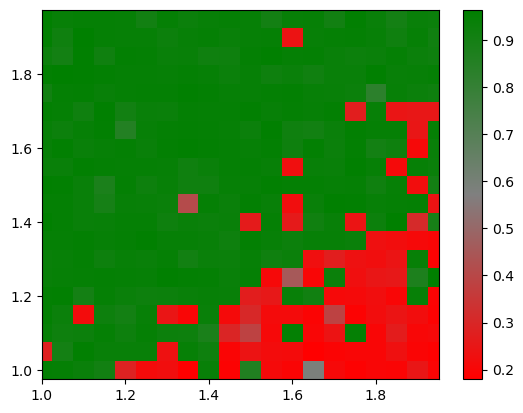

In [30]:
plt.pcolormesh(X,Y, z, cmap=cmap)
plt.colorbar()
plt.show()